In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout
import datetime

from sklearn.metrics import  mean_absolute_percentage_error, mean_absolute_error

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/StockData/STB-Historical-Data.csv',index_col=0,parse_dates=True).sort_values(by='Date',ascending=True)
df['Price']=df['Price'].replace(',','',regex=True).astype(float)

df = df.rename(columns={'Price': 'Close'})
df.head()


,Close,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-01-02,11600.0,"12,000.0","12,050.0","11,600.0",3.86M,-2.93%
2019-01-03,11100.0,"11,500.0","11,650.0","11,100.0",6.28M,-4.31%
2019-01-04,11150.0,"11,000.0","11,350.0","10,900.0",3.83M,0.45%
2019-01-07,11500.0,"11,400.0","11,600.0","11,350.0",3.70M,3.14%
2019-01-08,11350.0,"11,500.0","11,500.0","11,300.0",1.57M,-1.30%


In [3]:
df1 = df[['Close']]
df1

,Close
Date,
2019-01-02,11600.0
2019-01-03,11100.0
2019-01-04,11150.0
2019-01-07,11500.0
2019-01-08,11350.0
...,...
2023-06-12,28200.0
2023-06-13,28200.0
2023-06-14,27800.0


In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test val theo tỉ lệ
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [6]:
# 5. Hàm Create Dataset
#window sliding
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX),np.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+39 and Y=t+40
time_step = 40
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model=Sequential()

model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=40,verbose=1)

Epoch 1/100
22/22 [==============================] - 16s 57ms/step - loss: 0.0518 - val_loss: 0.0055
Epoch 2/100
22/22 [==============================] - 0s 11ms/step - loss: 0.0082 - val_loss: 0.0027
Epoch 3/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0047 - val_loss: 0.0021
Epoch 4/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 5/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 6/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 7/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 8/100
22/22 [==============================] - 0s 11ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 9/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 10/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0028 - val_loss: 0.001

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)


3/3 [==============================] - 0s 5ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
original_ytest = scaler.inverse_transform(ytest.reshape(-1,1))
original_yval = scaler.inverse_transform(yval.reshape(-1,1))


In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - original_yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - original_ytest)**2))
print(f"Validation RMSE: {valid_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")

Validation RMSE: 424.58
Testing RMSE: 799.12


In [14]:
# 13. Đánh giá độ chính xác thuật toán bằng MDA
def mda_cal(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - actual[:-1])).astype(int))

valid_mda = mda_cal(original_yval, y_pred_val)
test_mda = mda_cal(original_ytest,y_pred)
print(f"Validation MDA: {valid_mda* 100:.2f}%")
print(f"Testing MDA: {test_mda*100:.2f}%")

Validation MDA: 55.71%
Testing MDA: 43.48%


In [15]:
# 14. Đánh giá độ chính xác thuật toán bằng MAPE
valid_mape = mean_absolute_percentage_error(original_yval, y_pred_val)
test_mape = mean_absolute_percentage_error(original_ytest,y_pred)
print(f"Validation MAPE: {valid_mape* 100:.2f}%")
print(f"Testing MAPE: {test_mape*100:.2f}%")

Validation MAPE: 1.26%
Testing MAPE: 3.56%


In [16]:
# 15. Dự báo 30 ngày tiếp theo
skip_days = 60
val_len=len(val_data)
x_input=val_data[skip_days:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=val_len-skip_days
i=0
while(i<30):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.76083684]
53
1 day input [0.68651489 0.66374781 0.64273205 0.65499124 0.65323993 0.65323993
 0.65849387 0.67075306 0.64448336 0.65148862 0.65148862 0.63747811
 0.64448336 0.64098074 0.63922942 0.62171629 0.63397548 0.62521891
 0.63047285 0.62521891 0.61821366 0.64273205 0.64623468 0.66725044
 0.66900175 0.68301226 0.69001751 0.70402802 0.69001751 0.69702277
 0.71978984 0.73029772 0.72329247 0.70402802 0.69001751 0.69702277
 0.7145359  0.7145359  0.7145359  0.72504378 0.73555166 0.7267951
 0.73555166 0.73730298 0.71103327 0.72854641 0.73204904 0.73204904
 0.71803853 0.71803853 0.76007005 0.76083684]
1 day output [[0.76208806]]
2 day input [0.66374781 0.64273205 0.65499124 0.65323993 0.65323993 0.65849387
 0.67075306 0.64448336 0.65148862 0.65148862 0.63747811 0.64448336
 0.64098074 0.63922942 0.62171629 0.63397548 0.62521891 0.63047285
 0.62521891 0.61821366 0.64273205 0.64623468 0.66725044 0.66900175
 0.68301226 0.69001751 0.70402802 0.69001751 0.69702277 0.71978984
 0.73029772 0.72

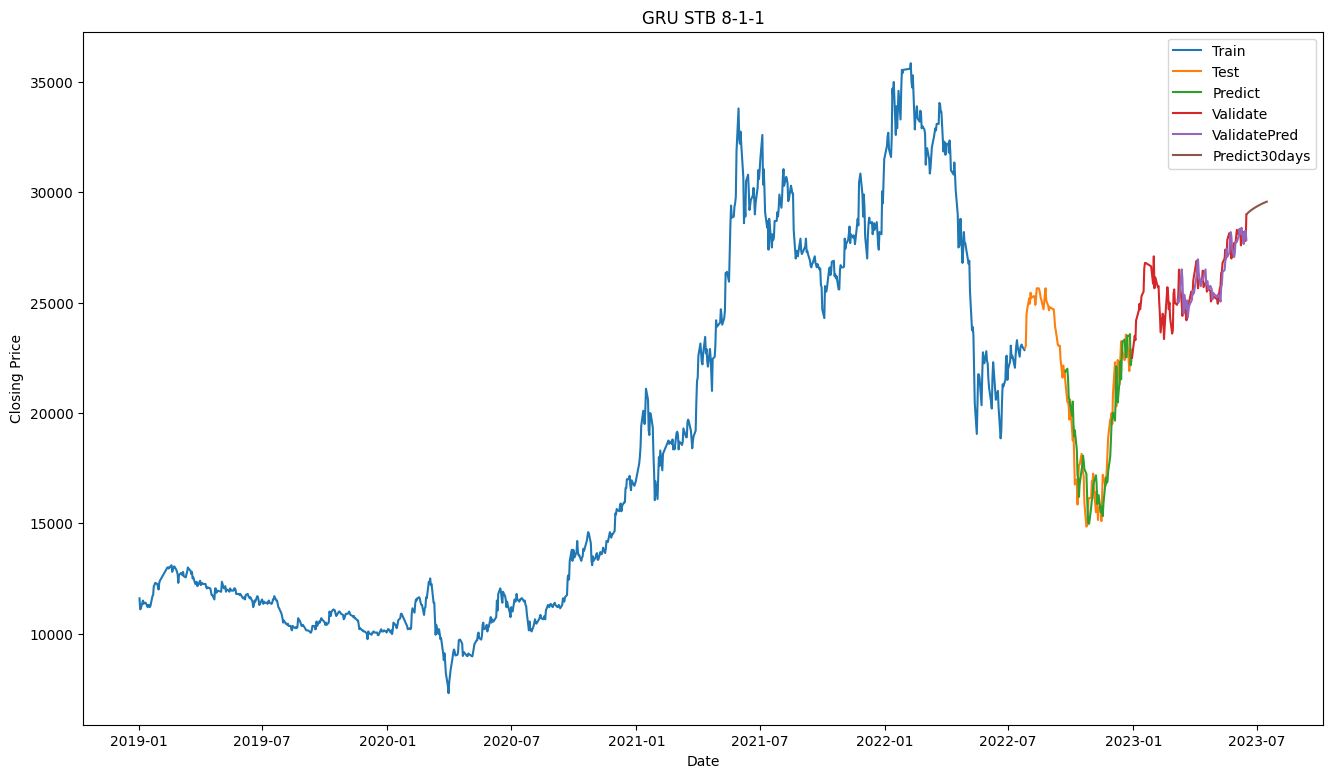

In [17]:
# 16.Vẽ hình
plt.figure(figsize=(16,9))
plt.ylabel('Closing Price');
plt.xlabel('Date');
plt.title('GRU STB 8-1-1')
train_index = df[:train_size].index
plt.plot(train_index,scaler.inverse_transform(train_data))
#test
test_index = df[train_size:train_size+test_size].index
plt.plot(test_index,scaler.inverse_transform(test_data))
#test predict
test_predict_index = df[train_size+41:train_size+test_size].index
plt.plot(test_predict_index,(y_pred))
#val
val_index = df[train_size+test_size:train_size+test_size+val_size].index
plt.plot(val_index,scaler.inverse_transform(val_data))
#val predict
val_predict_index = df[train_size+test_size+41:train_size+test_size+val_size].index
plt.plot(val_predict_index,y_pred_val)

start_period=df[-1:].index.date[0]
start_period=start_period+datetime.timedelta(days=1)
arr=pd.date_range(start_period,periods=30,freq='D')

plt.plot(arr,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()



In [18]:
print(scaler.inverse_transform(lst_output))

[[29021.89177275]
 [29057.61412382]
 [29089.81222808]
 [29117.26936102]
 [29142.09564626]
 [29165.90430737]
 [29188.90295327]
 [29211.17326617]
 [29232.79012144]
 [29253.79606187]
 [29274.22682345]
 [29294.10963356]
 [29313.4683162 ]
 [29332.3232919 ]
 [29350.68987608]
 [29368.58338416]
 [29386.01742983]
 [29403.0056268 ]
 [29419.55648363]
 [29435.68361402]
 [29451.39722824]
 [29466.70583487]
 [29481.61964417]
 [29496.14886642]
 [29510.30201018]
 [29524.08588231]
 [29537.51239479]
 [29550.58665276]
 [29563.31716478]
 [29575.71584284]]
